<a href="https://colab.research.google.com/github/Jushef/Proyectos-ML-DL/blob/main/Unsupervised%20Learning/Clustering/PortfolioManagementClusteringInvestors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Agrupación de individuos según sus características demográficas**

En este proyecto, utilizaremos métodos de agrupación para identificar diferentes tipos de inversores.

## **Contenido**

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1)
    * [4.3.Data Transformation](#3.2)  
* [5.Evaluate Algorithms and Models](#5)        
    * [5.1. k-Means Clustering](#5.1)
        * [5.1.1 Finding right number of clusters](#5.1.1)   
    * [5.2. Affinity Propagation Clustering](#5.2)
    * [5.3. Cluster Evaluation](#5.3)
* [6.Cluster Intuition](#6)   

<a id='0'></a>
# 1. Problem Definition

El objetivo de este estudio de caso es construir un modelo de aprendizaje automático para agrupar a los individuos/inversores en función de los parámetros relacionados con la capacidad y la voluntad de asumir riesgos. Para ello, nos centraremos en utilizar características demográficas y financieras comunes.

Para este estudio de caso, los datos utilizados proceden de la encuesta sobre las finanzas de los consumidores, realizada por la Junta de la Reserva Federal.

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [ ]:
# Carga de bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime

# Importar paquetes de modelos 
from sklearn.cluster import KMeans, AgglomerativeClustering,AffinityPropagation
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold


# Otros paquetes y funciones de ayuda
import matplotlib.ticker as ticker
from itertools import cycle

<a id='1.2'></a>
## 2.2. Loading the Data

In [ ]:
# cargar conjunto de datos
dataset = pd.read_excel('/content/ProcessedData.xlsx')

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
type(dataset)

pandas.core.frame.DataFrame

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [ ]:
# forma
dataset.shape

(3866, 13)

In [ ]:
# consultar los datos
set_option('display.width', 100)
dataset.head(5)

,ID,AGE,EDUC,MARRIED,KIDS,LIFECL,OCCAT,RISK,HHOUSES,WSAVED,SPENDMOR,NWCAT,INCCL
0,1,3,2,1,0,2,1,3,1,1,5,3,4
1,2,4,4,1,2,5,2,3,0,2,5,5,5
2,3,3,1,1,2,3,2,2,1,2,4,4,4
3,4,3,1,1,2,3,2,2,1,2,4,3,4
4,5,4,3,1,1,5,1,2,1,3,3,5,5


* Como podemos ver en la tabla anterior, hay 12 atributos para cada uno de los individuos. Estos atributos pueden clasificarse como demográficos, financieros y de comportamiento.

In [ ]:
# describir los datos
set_option('precision', 3)
dataset.describe()

,ID,AGE,EDUC,MARRIED,KIDS,LIFECL,OCCAT,RISK,HHOUSES,WSAVED,SPENDMOR,NWCAT,INCCL
count,3866.000,3866.000,3866.000,3866.000,3866.000,3866.000,3866.000,3866.000,3866.000,3866.000,3866.000,3866.000,3866.000
mean,1933.500,3.107,2.906,1.353,0.938,3.697,1.742,3.043,0.717,2.446,3.561,2.976,3.671
std,1116.162,1.513,1.066,0.478,1.249,1.618,0.934,0.879,0.451,0.743,1.304,1.463,1.184
min,1.000,1.000,1.000,1.000,0.000,1.000,1.000,1.000,0.000,1.000,1.000,1.000,1.000
25%,967.250,2.000,2.000,1.000,0.000,3.000,1.000,2.000,0.000,2.000,2.000,2.000,3.000
50%,1933.500,3.000,3.000,1.000,0.000,3.000,1.000,3.000,1.000,3.000,4.000,3.000,4.000
75%,2899.750,4.000,4.000,2.000,2.000,5.000,3.000,4.000,1.000,3.000,5.000,4.000,5.000
max,3866.000,6.000,4.000,2.000,8.000,6.000,4.000,4.000,1.000,3.000,5.000,5.000,5.000


<a id='2.2'></a>
## 3.2. Data Visualization

Veamos la correlación. Vamos a echar un vistazo detallado a la visualización después de la agrupación.

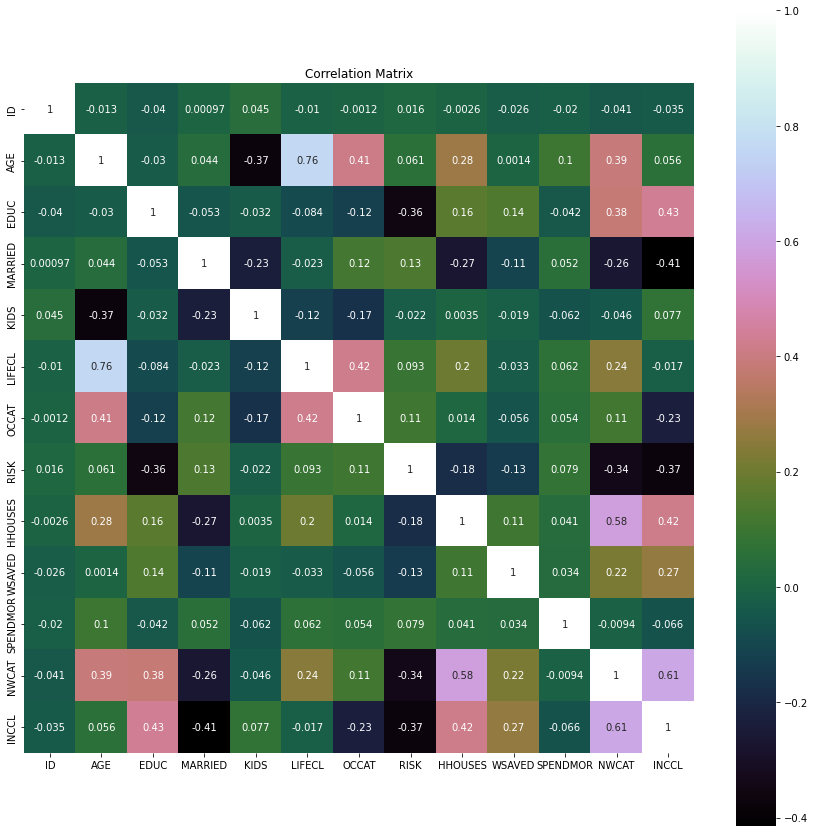

In [ ]:
# correlacion
from pylab import rcParams

#rcParams['figure.figsize'] = (15,15)
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

* Como puede verse en la imagen anterior, existe una correlación positiva significativa entre los valores.

<a id='3'></a>
## 4. Data Preparation

<a id='3.1'></a>
## 4.1. Data Cleaning

Comprobemos los NA en las filas, o bien los eliminamos o los rellenamos con la media de la columna.

In [ ]:
# Comprobación de los valores nulos y eliminación de los mismos'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


* Dado que no hay datos que falten y que los datos ya están en formato categórico, no se realizó ninguna otra limpieza de datos. La columna ID, que no es necesaria, se ha eliminado

In [ ]:
X=dataset.copy("deep")
X=X.drop(['ID'], axis=1)
X.head()

,AGE,EDUC,MARRIED,KIDS,LIFECL,OCCAT,RISK,HHOUSES,WSAVED,SPENDMOR,NWCAT,INCCL
0,3,2,1,0,2,1,3,1,1,5,3,4
1,4,4,1,2,5,2,3,0,2,5,5,5
2,3,1,1,2,3,2,2,1,2,4,4,4
3,3,1,1,2,3,2,2,1,2,4,3,4
4,4,3,1,1,5,1,2,1,3,3,5,5


<a id='3.2'></a>
## 4.2. Data Transformation

Los datos disponibles se componen de atributos con una escala similar. Por lo tanto, no es necesario transformar los datos.

<a id='5.1'></a>
## 5.1. K-Means Clustering

En este paso se observan las siguientes métricas para obtener el número óptimo de clusters.

1. Suma de errores cuadrados (SSE) dentro de los clusters,
2. Puntuación de la silueta.

<a id='5.1.1'></a>
### 5.1.1. Finding optimal number of clusters

Normalmente, se utilizan dos métricas para evaluar el número de clusters en el modelo K-means.

1. Suma de errores cuadrados (SSE) dentro de los clusters
2. Puntuación de la silueta

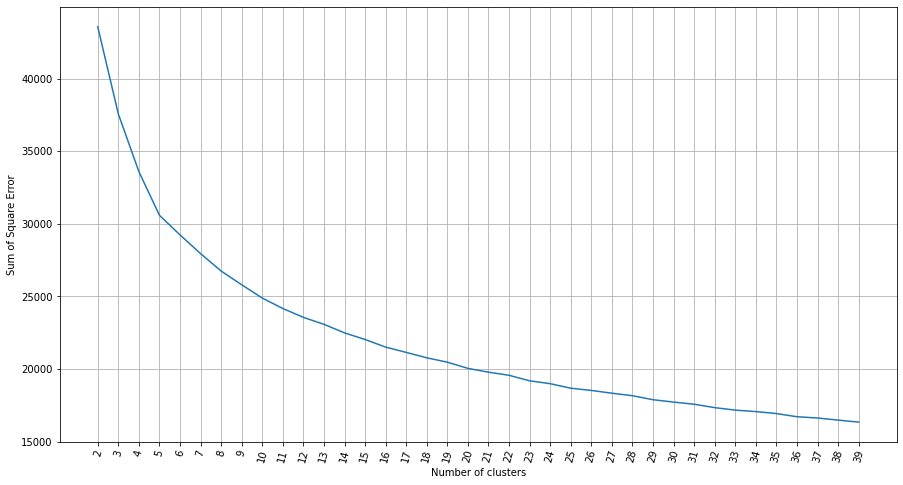

In [ ]:
rcParams['figure.figsize'] = (15, 8)

distorsions = []
max_loop=40
for k in range(2, max_loop):
    k_means = KMeans(n_clusters=k)
    k_means.fit(X)
    distorsions.append(k_means.inertia_)
plt.plot(range(2, max_loop), distorsions)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.xlabel("Number of clusters")
plt.ylabel("Sum of Square Error")
plt.grid(True)

#### **Silhouette score**

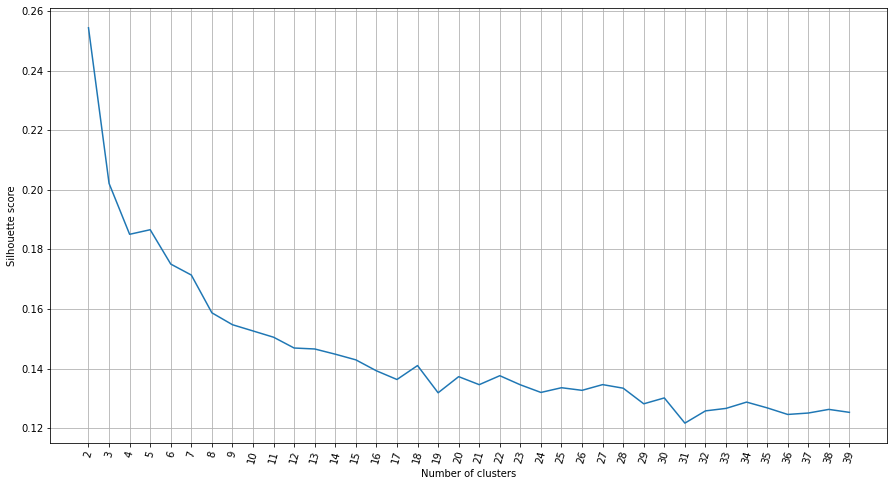

In [ ]:
from sklearn import metrics

silhouette_score = []
for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10)
        kmeans.fit(X)        
        silhouette_score.append(metrics.silhouette_score(X, kmeans.labels_, random_state=10))
plt.plot(range(2, max_loop), silhouette_score)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.grid(True)

Si se observan los dos gráficos anteriores, el número óptimo de conglomerados parece estar en torno a 7. Podemos ver que, a medida que el número de conglomerados pasa de 6, la suma del cuadrado de los errores dentro de los conglomerados se estabiliza. En el segundo gráfico, podemos ver que hay varias partes del gráfico en las que se aprecia una curvatura. Dado que no hay mucha diferencia en la SSE después de 7 clusters, utilizaremos 7 clusters en el modelo de k-means que se muestra a continuación.

<a id='5.1.2'></a>
### 5.1.2. Clustering and Visualisation

In [ ]:
nclust=7

In [ ]:
# Ajuste con k-means
k_means = cluster.KMeans(n_clusters=nclust)
k_means.fit(X)

KMeans(n_clusters=7)

In [ ]:
# Extracción de etiquetas 
target_labels = k_means.predict(X)

<a id='5.2'></a>
## 5.2. Affinity Propagation

In [ ]:
ap = AffinityPropagation(damping = 0.5, max_iter = 250, affinity = 'euclidean')
ap.fit(X)
clust_labels2 = ap.predict(X)

In [ ]:
cluster_centers_indices = ap.cluster_centers_indices_
labels = ap.labels_
n_clusters_ = len(cluster_centers_indices)
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 161


<a id='5.3'></a>
## 5.3. Cluster Evaluation

Evaluamos los clusters utilizando el Coeficiente de Silueta (sklearn.metrics.silhouette_score). Una puntuación de Coeficiente de Silueta más alta significa un modelo con clusters mejor definidos.

In [ ]:
from sklearn import metrics
print("km", metrics.silhouette_score(X, k_means.labels_, metric='euclidean'))
print("ap", metrics.silhouette_score(X, ap.labels_, metric='euclidean'))

km 0.17119987137780202
ap 0.09733518906949089


* k-means tiene un coeficiente de silueta mucho mayor que la propagación por afinidad.

<a id='6'></a>
# 6. Cluster Intuition

En el siguiente paso, comprobaremos cada cluster y entenderemos la intuición que hay detrás de los clusters.

In [ ]:
cluster_output= pd.concat([pd.DataFrame(X), pd.DataFrame(k_means.labels_, columns = ['cluster'])],axis = 1)
output=cluster_output.groupby('cluster').mean()
output

,AGE,EDUC,MARRIED,KIDS,LIFECL,OCCAT,RISK,HHOUSES,WSAVED,SPENDMOR,NWCAT,INCCL
cluster,,,,,,,,,,,,
0,2.508,3.583,1.102,2.275,3.144,1.469,2.513,0.954,2.686,3.474,4.271,4.702
1,4.839,2.157,1.578,0.186,5.621,2.373,3.555,0.710,2.268,3.900,2.363,2.677
2,1.801,2.695,1.643,0.007,1.364,1.649,3.233,0.299,2.369,3.450,1.486,2.695
3,1.898,2.408,1.329,2.118,3.353,1.443,3.380,0.512,2.241,4.525,1.712,3.110
4,4.666,3.458,1.226,0.299,5.351,2.077,2.745,0.942,2.624,3.551,4.515,4.506
5,1.946,2.448,1.287,1.974,3.315,1.399,3.266,0.520,2.205,1.963,1.802,3.252
6,2.348,3.387,1.368,0.126,1.759,1.333,2.705,0.857,2.624,3.720,3.547,4.350


### **Demographics Features**

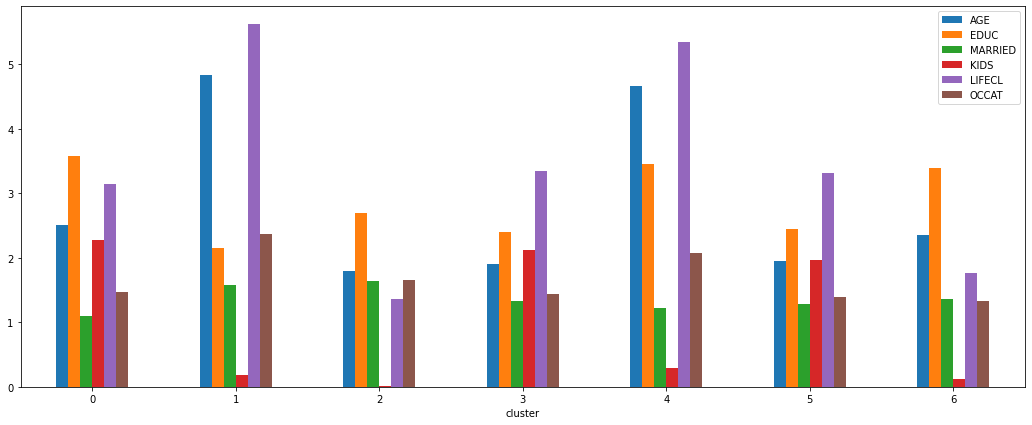

In [ ]:
output[['AGE','EDUC','MARRIED','KIDS','LIFECL','OCCAT']].plot.bar(rot=0, figsize=(18,7));

* El gráfico muestra el valor medio de los atributos para cada uno de los clusters. Por ejemplo, comparando el cluster 0 y el cluster 1, el cluster 0 tiene una edad media más baja, pero una educación media más alta. En términos de matrimonio y número de hijos, estos dos clusters son similares. Por lo tanto, los individuos del cluster 0 tendrán de media una mayor tolerancia al riesgo en comparación con los individuos del cluster 1, basándose en los atributos demográficos.

### **Financial Features and Features related to willingness to take risk**

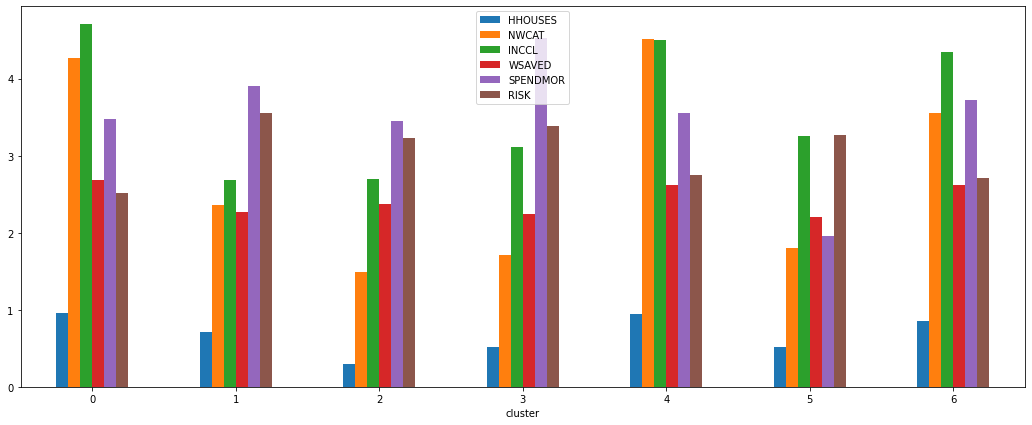

In [ ]:
output[['HHOUSES','NWCAT','INCCL','WSAVED','SPENDMOR','RISK']].plot.bar(rot=0, figsize=(18,7));

* El gráfico muestra el valor medio de los atributos para cada uno de los clusters en los atributos financieros y de comportamiento. Por ejemplo, comparando el cluster 0 y el cluster 1, el cluster 0 tiene una media más alta de propiedad de la vivienda, una media más alta de patrimonio neto e ingresos, y una menor disposición a asumir riesgos. En cuanto a la comparación del ahorro con la renta y la disposición a ahorrar, los dos clusters son comparables. Por lo tanto, podemos afirmar que los individuos del grupo 0 tendrán, por término medio, una mayor capacidad, aunque menor voluntad, de asumir riesgos en comparación con el grupo 1.

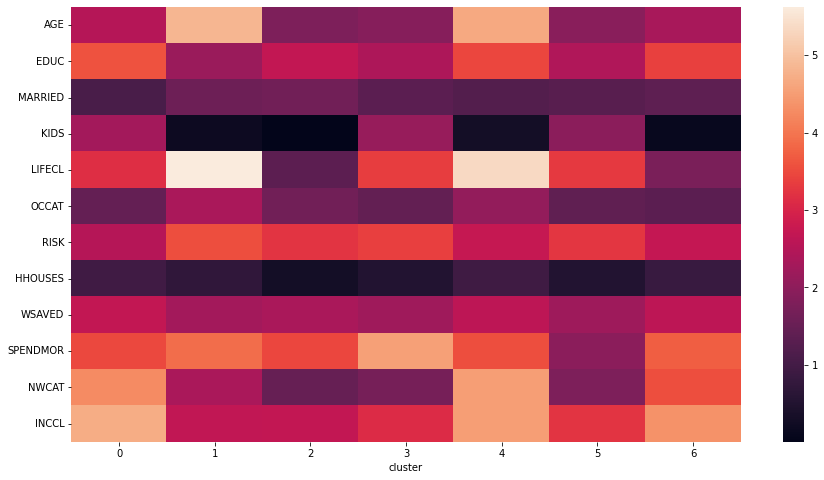

In [ ]:
sns.heatmap(output.T)

Combinando la información de los atributos demográficos, financieros y de comportamiento del clúster 0 y del clúster 1, la capacidad general de asumir riesgos del clúster 0 es mayor que la del clúster 1. Realizando un análisis similar en todas las demás agrupaciones, resumimos los resultados en la siguiente tabla. La columna de tolerancia al riesgo representa la evaluación subjetiva de la tolerancia al riesgo de cada uno de los grupos.

| Cluster| Features | Risk Capacity |
| --- | --- | --- |
| Cluster 0	 | Edad baja, patrimonio e ingresos elevados, categoría de vida menos arriesgada, disposición a gastar más | Alta |
| Cluster 1	 | Edad elevada, patrimonio e ingresos bajos, categoría de vida muy arriesgada, disposición a asumir riesgos, baja educación | Alta |
| Cluster 2	 | Edad alta, patrimonio e ingresos elevados, categoría de vida muy arriesgada, disposición a asumir riesgos, casa propia | Media |
| Cluster 3	 | 	Edad baja, ingresos y patrimonio neto muy bajos, alta disposición a asumir riesgos, muchos hijos | Baja |
| Cluster 4	 | Edad media, ingresos y patrimonio neto muy elevados, alta disposición a asumir riesgos, muchos hijos, casa propia | Alta |
| Cluster 5	 | Edad baja, ingresos y patrimonio neto muy bajos, alta disposición a asumir riesgos, sin hijos | Media |
| Cluster 6	 | Edad baja, ingresos y patrimonio medios, alta disposición a asumir riesgos, muchos hijos, casa propia | Baja |


## **Conclución**
Una de las claves de este proyecto es el enfoque para entender la intuición de los clusters. Utilizamos técnicas de visualización para comprender el comportamiento esperado de un miembro de un clúster mediante la interpretación cualitativa de los valores medios de las variables de cada clúster.

Demostramos la eficacia de la técnica de clustering para descubrir los grupos intuitivos naturales de los diferentes inversores en función de su tolerancia al riesgo.

Dado que los algoritmos de clustering pueden agrupar con éxito a los inversores en función de diferentes factores, como la edad, los ingresos y la tolerancia al riesgo, los gestores de carteras pueden utilizarlos para comprender el comportamiento de los inversores y estandarizar la asignación y el reequilibrio de las carteras en los clusters, haciendo que el proceso de gestión de las inversiones sea más rápido y eficaz.